#Test data trajectory analysis

To generate synthetic sequences we need "paths" that control the movement of the object in the scene. The most obvious source for a generative model for "natural" paths are the test sequences inside the tracking datasets. 

The are many ways to analyze this data. We will try some of these alternatives, starting by a mapping to our synthetic generation model i.e. 5 degrees of freedom (DOF) corresponding to rotation, scaling and translation. The first point analyzed was that as the ground truth bounding boxes are axis-aligned, it is difficult to infer rotation information directly from the box. Therefore, our first visualizations belong to only scaling and translation transformations i.e. 4 DOF.

In [17]:
#Helper functions

def read_gt(gtPath):
    gtFile = open(gtPath, 'r')
    lines = gtFile.readlines()
    #TODO: better replacement of whitespace
    gt = [map(float, line.strip().replace(',', ' ').split()) for line in lines]
    gtFile.close()
    return gt

In [18]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [19]:
from PIL import Image, ImageDraw
import numpy
import os
import matplotlib
import matplotlib.pyplot
import IPython.display
import animator

In [20]:
gtPath = '/home/datasets/datasets1/vot-challenge/sequences/motocross//groundtruth.txt'
gt = read_gt(gtPath)

In [21]:
frameSize = Image.open(os.path.join(os.path.dirname(gtPath), '00000001.jpg')).size

In [22]:
image = Image.new('RGBA', frameSize)
canvas = ImageDraw.ImageDraw(image)

In [33]:
for box in gt:
    canvas.polygon(box)

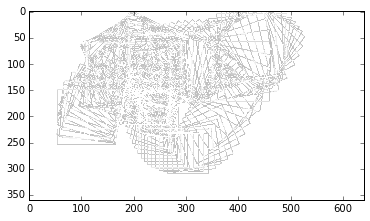

In [34]:
matplotlib.pyplot.imshow(numpy.asarray(image))

In [104]:
predictedPointsList[0]

array([ 246.37,   80.74,  224.66,  203.84,   96.63,  181.26,  118.34,
         58.16])

In [102]:
output = '/tmp/video.mp4'
sequence = (draw_polygon(os.path.join(os.path.dirname(gtPath), imagePath), gt[i]) for i, imagePath in enumerate(sorted(os.listdir(os.path.dirname(gtPath)))) if imagePath.endswith('.jpg'))
%time animator.frames2video(sequence, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 3.11 s, sys: 32 ms, total: 3.15 s
Wall time: 4.98 s


In [92]:
def draw_polygon(imagePath, polygon):
    image = Image.open(imagePath)
    draw = ImageDraw.ImageDraw(image)
    draw.polygon(polygon)
    return image

In [94]:
#NOTE: Depends on transformation order: T*S*R
def transform_params(transform):
    x = transform[0,-1]
    y = transform[1,-1]
    theta = numpy.arctan2(transform[0,1],transform[0,0])
    ratio = numpy.abs(transform[0,0]/transform[1,1])
    product = numpy.abs(transform[0,0]*transform[1,1]-transform[0,1]*transform[1,0])
    print 'Product: {}\tRatio: {}\tDividends: {}, {}\tTheta: {}\t Cos: {}\tSin: {}'.format(product, ratio, transform[0,0], transform[1,1], theta, numpy.cos(theta), numpy.sin(theta))
    sy = numpy.sqrt(product/ratio)
    sx = ratio*sy
    return x,y,sx,sy,theta

In [75]:
def homogeneous_points(coordinates, dims=2):
    values = numpy.reshape(coordinates, (len(coordinates)/2, dims)).T
    points = numpy.vstack([values, numpy.ones((1, values.shape[1]))])
    return points

In [76]:
refPoints = homogeneous_points(gt[0])

In [100]:
path = numpy.empty((0,5))
averageDiff = 0
predictedPointsList = [refPoints[:2,:].T.flatten()]
for i in range(1,len(gt)):
    points = homogeneous_points(gt[i])
    transform = numpy.dot(points, numpy.linalg.pinv(refPoints))
    params = transform_params(transform)
    path = numpy.vstack([path, params])
    tx, ty, sx, sy, theta = params
    predictedTransform = numpy.array([[sx*numpy.cos(theta), sx*numpy.sin(theta), tx],[-sy*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
    predictedPoints = numpy.dot(predictedTransform, refPoints)
    predictedPointsList.append(predictedPoints[:2,:].T.flatten())
    currentDiff = numpy.linalg.norm(points-predictedPoints)
    print 'Current difference[{}]: {}'.format(i, currentDiff)
    averageDiff += currentDiff
averageDiff /= len(gt)-1
print 'Average difference: {}'.format(averageDiff)

Product: 0.98519634053	Ratio: 0.999430558208	Dividends: 0.987363464999, 0.987926031368	Theta: 0.0995971023125	 Cos: 0.995044307172	Sin: 0.0994325236776
Current difference[1]: 0.0533725004061
Product: 0.970609754723	Ratio: 0.998700022511	Dividends: 0.965052371144, 0.966308550507	Theta: 0.199431942019	 Cos: 0.980179275405	Sin: 0.198112564129
Current difference[2]: 0.0487249466586
Product: 0.956037085235	Ratio: 0.998036575375	Dividends: 0.933471463958, 0.935307870462	Theta: 0.299243168945	 Cos: 0.955559874369	Sin: 0.294797093772
Current difference[3]: 0.194647771041
Product: 0.941644604854	Ratio: 0.99733706058	Dividends: 0.893093621392, 0.895478225658	Theta: 0.399206862387	 Cos: 0.921369566601	Sin: 0.388687691781
Current difference[4]: 0.446595906297
Product: 0.927326890462	Ratio: 0.996515506111	Dividends: 0.844388583072, 0.84734113809	Theta: 0.49927124515	 Cos: 0.877931712511	Sin: 0.478785868805
Current difference[5]: 0.812618691034
Product: 0.913127564781	Ratio: 0.995665345729	Dividends

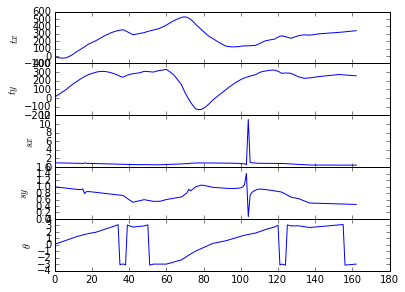

In [91]:
titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $']
matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
for i in range(path.shape[1]):
    axes = matplotlib.pyplot.subplot(path.shape[1],1,i+1)
    matplotlib.pyplot.plot(path[:,i])
    if i < path.shape[1]-1:
        matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
    matplotlib.pyplot.ylabel(titles[i])
#matplotlib.pyplot.tight_layout()